<a href="https://colab.research.google.com/github/Suraalani79/msc-dissertation-2025/blob/main/framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSc Dissertation — Adaptive, Modular, Multi-Agent AI Framework for SMEs
**Notebook:** End-to-end pipeline (datasets → preprocessing → modelling → evaluation → adaptivity)

> Keep this notebook in sync with Chapter 3 (Methodology). Each section here maps to 3.x sections.

---

## 1. Dataset Loading
- Online Retail II (UCI): customer transactions (segmentation/demand)
- South German Credit (UCI): credit risk classification
- Bank Marketing (UCI): campaign response prediction

*Goal:* Load CSVs from Google Drive or direct URLs and show basic shapes/columns.

---

## 2. Preprocessing & Feature Engineering
- Handle missing values, duplicates, outliers
- Encode categoricals, scale numerics
- Task-specific features (e.g., RFM for retail)

*Goal:* Produce clean `X_train`, `X_test`, `y_train`, `y_test` (if supervised).

---

## 3. Modelling (per “agent” / task)
- **Risk (classification):** Logistic Regression (baseline) → Random Forest / XGBoost
- **Segmentation (clustering):** k-Means with Silhouette
- *(Optional)* Forecasting: add later if time permits

*Goal:* Train models with cross-validation and save metrics.

---

## 4. Evaluation & Reporting
- Classification: Accuracy, Precision, Recall, F1, ROC-AUC
- Clustering: Silhouette
- Compare **static** vs **retrainable** runs (later)

*Goal:* Store results in `/results/` as CSV/PNG.

---

## 5. Adaptivity (Continual Learning / Retraining)
- Simple retraining strategy (scheduled or drift-triggered)
- Document when/why a model is retrained and how performance changes

---

## 6. Repro Notes
- Library versions, random seeds, data sources
- Ethical/Legal note: public, non-personal datasets only (UCI)

---


In [2]:
# Core
import os, sys, pathlib, warnings
warnings.filterwarnings("ignore")

# Data
import numpy as np
import pandas as pd

# Prep & models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# XGBoost optional: pip install xgboost then uncomment
# from xgboost import XGBClassifier

from sklearn.cluster import KMeans

# Utils
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Results directory (matches your repo structure)
RESULTS_DIR = pathlib.Path("results")
RESULTS_DIR.mkdir(exist_ok=True)


In [3]:
# === Direct UCI downloads: Online Retail, German Credit, Bank Marketing ===
import os, io, zipfile, urllib.request
import pandas as pd

DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

def fetch(url, out_path):
    try:
        urllib.request.urlretrieve(url, out_path)
        print(f"✓ Downloaded: {out_path}")
        return True
    except Exception as e:
        print(f"⚠️ Could not download {url}\n{e}")
        return False

# ---------------------------
# 1) Online Retail (UCI)
# ---------------------------
# NOTE: UCI sometimes hosts “Online Retail II” with access restrictions.
# We’ll try Online Retail II first; if it fails, we fall back to the classic Online Retail.
retail_xlsx_path = os.path.join(DATA_DIR, "OnlineRetail.xlsx")

online_retail_ii_urls = [
    # Try Online Retail II first (may require access; if it fails, we fall back)
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx",
    # Fallback to classic Online Retail
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx",
]

retail_ok = False
for u in online_retail_ii_urls:
    if fetch(u, retail_xlsx_path):
        retail_ok = True
        break

retail_df = None
if retail_ok:
    try:
        # Some versions have multiple sheets; sheet_name=None loads dict of sheets
        tmp = pd.read_excel(retail_xlsx_path, sheet_name=None)
        # If multiple sheets, concat them; otherwise use the single one
        if isinstance(tmp, dict):
            retail_df = pd.concat(tmp.values(), ignore_index=True)
        else:
            retail_df = tmp
        print("✓ Online Retail loaded:", retail_df.shape)
    except Exception as e:
        print("⚠️ Could not read Online Retail Excel:", e)

# ---------------------------
# 2) German Credit (Statlog) – UCI
# ---------------------------
# Raw file (no header). Use names from UCI documentation or create generic ones.
german_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
german_path = os.path.join(DATA_DIR, "german.data")
if fetch(german_url, german_path):
    # 20 features + 1 target (per UCI description). We’ll name C1..C20 and 'target'
    col_names = [f"C{i}" for i in range(1, 21)] + ["target"]
    credit_df = pd.read_csv(german_path, sep=r"\s+", header=None, names=col_names, engine="python")
    print("✓ German Credit loaded:", credit_df.shape)
else:
    credit_df = None

# ---------------------------
# 3) Bank Marketing – UCI (use “bank-additional-full.csv”)
# ---------------------------
bank_zip_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
bank_zip_path = os.path.join(DATA_DIR, "bank-additional.zip")
bank_df = None

if fetch(bank_zip_url, bank_zip_path):
    try:
        with zipfile.ZipFile(bank_zip_path, "r") as z:
            # prefer the full dataset inside the zip
            candidates = [
                "bank-additional/bank-additional-full.csv",
                "bank-additional/bank-additional.csv",        # smaller version
                "bank/bank-full.csv"                           # older folder name in some mirrors
            ]
            member = None
            for c in candidates:
                if c in z.namelist():
                    member = c
                    break
            if member is None:
                raise FileNotFoundError(f"None of expected CSVs found. Available: {z.namelist()[:5]} ...")

            with z.open(member) as f:
                bank_df = pd.read_csv(f, sep=';')
        print("✓ Bank Marketing loaded:", bank_df.shape)
    except Exception as e:
        print("⚠️ Could not extract/read Bank Marketing:", e)

# ---------------------------
# Quick peek (if loaded)
# ---------------------------
for name, df in [("Retail", retail_df), ("Credit", credit_df), ("Bank", bank_df)]:
    if df is not None:
        print(f"\n{name} head():")
        display(df.head())


✓ Downloaded: /content/data/OnlineRetail.xlsx
✓ Online Retail loaded: (1067371, 8)
✓ Downloaded: /content/data/german.data
✓ German Credit loaded: (1000, 21)
✓ Downloaded: /content/data/bank-additional.zip
✓ Bank Marketing loaded: (41188, 21)

Retail head():


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom



Credit head():


,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C12,C13,C14,C15,C16,C17,C18,C19,C20,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2



Bank head():


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# 1) Credit risk (classification) — Logistic Regression vs Random Forest

# --- CREDIT: preprocessing + models + metrics ---
from sklearn.impute import SimpleImputer

credit = credit_df.copy()

# Separate target (last column named 'target' in the UCI German dataset used here)
y_credit = credit['target'] if 'target' in credit else credit.iloc[:, -1]
X_credit = credit.drop(columns=y_credit.name)

# Identify cat vs num
cat_cols = [c for c in X_credit.columns if X_credit[c].dtype == 'object']
num_cols = [c for c in X_credit.columns if c not in cat_cols]

preprocess_credit = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('scaler', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                          ('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
    ]
)

models = {
    'logreg': LogisticRegression(max_iter=1000, n_jobs=None),
    'rf': RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)
}

from collections import defaultdict
rows = []

X_train, X_test, y_train, y_test = train_test_split(
    X_credit, y_credit, test_size=0.2, random_state=RANDOM_STATE, stratify=y_credit
)

for name, clf in models.items():
    pipe = Pipeline([('prep', preprocess_credit), ('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    if hasattr(pipe['clf'], "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None

    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='binary', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='binary', zero_division=0),
        'f1': f1_score(y_test, y_pred, average='binary', zero_division=0),
        'roc_auc': auc
    }
    rows.append(metrics)

credit_results = pd.DataFrame(rows).sort_values(by='f1', ascending=False)
display(credit_results)

credit_results.to_csv(RESULTS_DIR / 'credit_metrics.csv', index=False)
print(f"Saved: {RESULTS_DIR/'credit_metrics.csv'}")


,model,accuracy,precision,recall,f1,roc_auc
0,logreg,0.780,0.815789,0.885714,0.849315,0.804048
1,rf,0.765,0.785276,0.914286,0.844884,0.789643


Saved: results/credit_metrics.csv


In [5]:
# 2) Bank marketing (classification) — Logistic Regression vs Random Forest
# --- BANK: preprocessing + models + metrics ---
bank = bank_df.copy()

# Target is `y` (yes/no). Convert to 1/0.
if 'y' in bank.columns:
    bank['y'] = (bank['y'].astype(str).str.lower() == 'yes').astype(int)
y_bank = bank['y']
X_bank = bank.drop(columns=['y'])

cat_cols = [c for c in X_bank.columns if X_bank[c].dtype == 'object']
num_cols = [c for c in X_bank.columns if c not in cat_cols]

preprocess_bank = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('scaler', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                          ('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
    ]
)

models = {
    'logreg': LogisticRegression(max_iter=1000, n_jobs=None),
    'rf': RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)
}

rows = []
X_train, X_test, y_train, y_test = train_test_split(
    X_bank, y_bank, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bank
)

for name, clf in models.items():
    pipe = Pipeline([('prep', preprocess_bank), ('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe['clf'], "predict_proba") else None

    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }
    rows.append(metrics)

bank_results = pd.DataFrame(rows).sort_values(by='f1', ascending=False)
display(bank_results)

bank_results.to_csv(RESULTS_DIR / 'bank_metrics.csv', index=False)
print(f"Saved: {RESULTS_DIR/'bank_metrics.csv'}")


,model,accuracy,precision,recall,f1,roc_auc
1,rf,0.919398,0.711538,0.478448,0.572165,0.947772
0,logreg,0.916606,0.711775,0.436422,0.541082,0.942437


Saved: results/bank_metrics.csv


In [6]:
# 3) Online Retail (segmentation) — RFM features + K-Means
# --- RETAIL: RFM features + KMeans clustering ---
retail = retail_df.copy()

# Basic cleaning
retail = retail.rename(columns=str.strip)
if 'InvoiceDate' in retail.columns:
    retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], errors='coerce')
retail = retail.dropna(subset=['Customer ID']) if 'Customer ID' in retail.columns else retail
retail = retail[retail.get('Quantity', 1) > 0]

# Monetary value (Price * Quantity)
if {'Price','Quantity'}.issubset(retail.columns):
    retail['Total'] = retail['Price'] * retail['Quantity']

# Build simple RFM by Customer ID
id_col = 'Customer ID' if 'Customer ID' in retail.columns else retail.columns[-1]
now_date = retail['InvoiceDate'].max() if 'InvoiceDate' in retail.columns else pd.Timestamp.today()

rfm = (
    retail.groupby(id_col).agg({
        'InvoiceDate': lambda s: (now_date - s.max()).days if 'InvoiceDate' in retail.columns else 0,
        'Invoice': 'nunique' if 'Invoice' in retail.columns else 'size',
        'Total': 'sum' if 'Total' in retail.columns else 'size'
    })
    .rename(columns={'InvoiceDate':'Recency','Invoice':'Frequency','Total':'Monetary'})
    .reset_index()
)

# Scale and KMeans
features = ['Recency','Frequency','Monetary']
rfm[features] = rfm[features].fillna(0)
scaler = StandardScaler()
X = scaler.fit_transform(rfm[features])

kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init='auto')
labels = kmeans.fit_predict(X)

rfm['cluster'] = labels
sil = silhouette_score(X, labels)
print(f"Silhouette score (k=4): {sil:.3f}")

display(rfm.head())

# Save clusters
rfm.to_csv(RESULTS_DIR / 'retail_rfm_clusters.csv', index=False)
print(f"Saved: {RESULTS_DIR/'retail_rfm_clusters.csv'}")


Silhouette score (k=4): 0.591


,Customer ID,Recency,Frequency,Monetary,cluster
0,12346.0,325,12,77556.46,0
1,12347.0,1,8,5633.32,0
2,12348.0,74,5,2019.40,0
3,12349.0,18,4,4428.69,0
4,12350.0,309,1,334.40,1


Saved: results/retail_rfm_clusters.csv


In [7]:
# 4) Save a one-page summary of results
summary = {
    'credit_best_f1': float(credit_results['f1'].max()),
    'bank_best_f1'  : float(bank_results['f1'].max()),
    'retail_silhouette': float(sil)
}
pd.DataFrame([summary]).to_csv(RESULTS_DIR / 'summary.csv', index=False)
pd.DataFrame([summary])


,credit_best_f1,bank_best_f1,retail_silhouette
0,0.849315,0.572165,0.59054


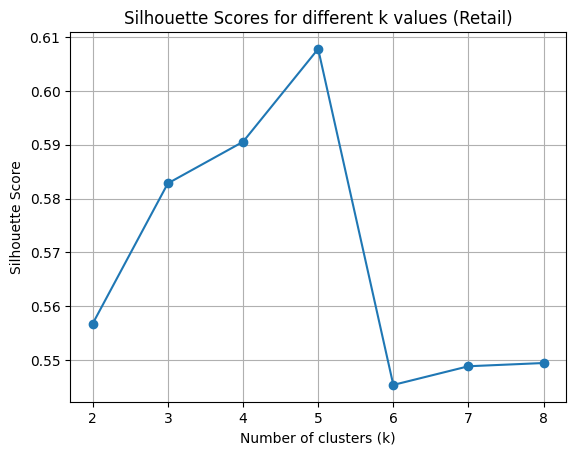

,k,silhouette
0,2,0.556790
1,3,0.582828
2,4,0.590540
3,5,0.607787
4,6,0.545410
5,7,0.548876
6,8,0.549477


In [8]:
# 5) Silhouette analysis for different k values (Retail dataset)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

features = ['Recency', 'Frequency', 'Monetary']
X = scaler.fit_transform(rfm[features].fillna(0))

sil_scores = []
for k in range(2, 9):  # test k=2 to 8
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append({'k': k, 'silhouette': score})

# Save results
sil_df = pd.DataFrame(sil_scores)
sil_df.to_csv(RESULTS_DIR / 'silhouette_scores.csv', index=False)

# Plot
plt.plot(sil_df['k'], sil_df['silhouette'], marker='o')
plt.title("Silhouette Scores for different k values (Retail)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

display(sil_df)


In [11]:
# 6) Helper function: plot confusion matrix for the best classifier

# 6) Helper function — plot confusion matrix for the best classifier (by F1)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def plot_cm_for_dataset(X, y, preprocessor, results_df, dataset_name, filename_prefix):
    # pick best model by F1
    best_row = results_df.sort_values("f1", ascending=False).iloc[0]
    best_name = str(best_row["model"]).lower()
    if best_name in ("rf", "randomforest", "random_forest"):
        clf = RandomForestClassifier(random_state=RANDOM_STATE)
    else:
        clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

    # split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    # pipeline = preprocess -> clf
    pipe = Pipeline([("prep", preprocessor), ("clf", clf)])
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)

    # Confusion matrix
    cm = confusion_matrix(y_te, y_pred, labels=np.unique(y))
    disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"{dataset_name}: Confusion Matrix (best={best_name})")
    fig.tight_layout()
    out_path = RESULTS_DIR / f"{filename_prefix}_cm.png"
    fig.savefig(out_path, dpi=160)
    plt.show()
    print(f"Saved: {out_path}")

    # Classification report (printed)
    print("\nClassification report:")
    print(classification_report(y_te, y_pred, digits=3))



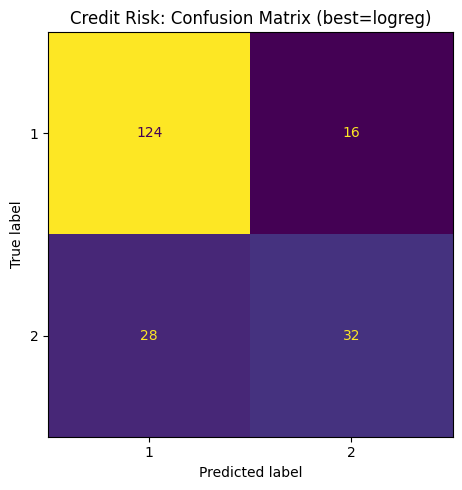

Saved: results/credit_best_cm.png

Classification report:
              precision    recall  f1-score   support

           1      0.816     0.886     0.849       140
           2      0.667     0.533     0.593        60

    accuracy                          0.780       200
   macro avg      0.741     0.710     0.721       200
weighted avg      0.771     0.780     0.772       200



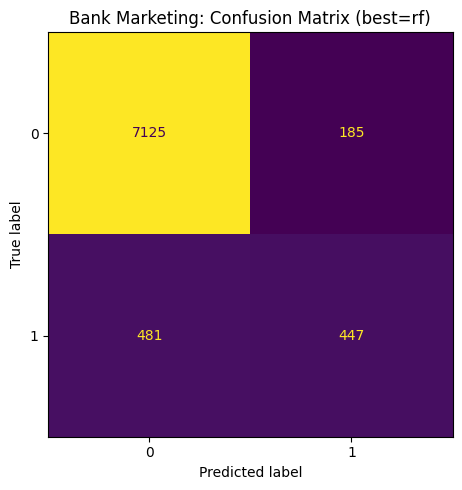

Saved: results/bank_best_cm.png

Classification report:
              precision    recall  f1-score   support

           0      0.937     0.975     0.955      7310
           1      0.707     0.482     0.573       928

    accuracy                          0.919      8238
   macro avg      0.822     0.728     0.764      8238
weighted avg      0.911     0.919     0.912      8238



In [12]:
# 7) Confusion matrices — Credit & Bank (using the helper)

# 7) Confusion matrices — Credit & Bank

# ---- CREDIT
X_credit = credit_df.drop(columns=["target"])          # adjust 'target' if your column name differs
y_credit = credit_df["target"].astype(int)
plot_cm_for_dataset(
    X_credit, y_credit, preprocess_credit, credit_results,
    dataset_name="Credit Risk", filename_prefix="credit_best"
)

# ---- BANK
X_bank_full = bank_df.drop(columns=["y"])

# Map 'no'/'yes' -> 0/1 safely (and handle '0'/'1' strings)
y_bank_full = bank_df["y"].astype(str).str.strip().map({"no": 0, "yes": 1, "0": 0, "1": 1}).astype(int)

plot_cm_for_dataset(
    X_bank_full, y_bank_full, preprocess_bank, bank_results,
    dataset_name="Bank Marketing", filename_prefix="bank_best"
)

